In [14]:
import pandas as pd
import re
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

from sklearn.utils import resample
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score

In [15]:
root_path = "data/types.csv"
df = pd.read_csv(root_path, encoding='latin1')
# df.drop(columns=['Unnamed: 1'], inplace=True)
df.head()

,review_text,type
0,We had a wonderful Saturday night dinner.,4
1,They had a fire dancer by the beach and a musi...,3
2,The seafood grill was good and their buttered ...,1
3,The grilled lamb was very chewy and not edible...,1
4,the service was good for a packed restaurant,2


In [16]:
df.dropna()

,review_text,type
0,We had a wonderful Saturday night dinner.,4
1,They had a fire dancer by the beach and a musi...,3
2,The seafood grill was good and their buttered ...,1
3,The grilled lamb was very chewy and not edible...,1
4,the service was good for a packed restaurant,2
...,...,...
1311,But the food is good though.,1
1312,Good value for money,4
1313,Sea breeze can be a disturbance sometimes.,3
1314,You can have best view for watching sunsets.,3


In [17]:
df.shape

(1316, 2)

In [18]:
train, test = train_test_split(df, test_size=0.15)


In [19]:
print("training dataset size", train.shape)
print("testing dataset size", test.shape)

training dataset size (1118, 2)
testing dataset size (198, 2)


c:\users\hp\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


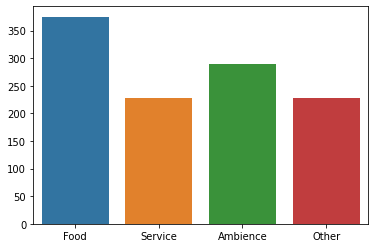

In [20]:
food_count = len(train[train.type == 1])
service_count = len(train[train.type == 2])
ambience_count = len(train[train.type == 3])
other_count = len(train[train.type == 4])

x = ["Food", "Service", "Ambience", "Other"]
y = [food_count, service_count, ambience_count, other_count]

sns.barplot(x, y)
plt.show()

In [23]:
def  clean_text(df, text_field): #
    # This function removes all unnecessary characters from the text
    df[text_field] = df[text_field].str.lower()
    df[text_field] = df[text_field].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))  
    return df

train_clean = clean_text(train, "review_text")
test_clean = clean_text(train, "review_text")

In [24]:
train_clean.head(15)

,review_text,type
1039,mouthwatering foods,1
1221,fast service despite too much crowded,2
1032,they do have a child friendly menu so a great ...,1
711,foods are great delicious good selection incl...,1
1231,the service bit slow,2
1251,really good night place to hang out with frien...,4
965,the price with service charge vat nbt is a bi...,4
831,super band and the hot butter cuttlefish was ...,1
389,enjoyed sitting under the trees friendly staff...,3
294,however there are lot of flies around,3


In [25]:
# upsampling 
train_food = train_clean[train_clean.type == 1] # target max count to upsample data
train_service = train_clean[train_clean.type == 2]
train_ambience = train_clean[train_clean.type == 3] 
train_other = train_clean[train_clean.type == 4]

train_ambience_upsampled = resample(train_ambience, replace=True, n_samples=len(train_food), random_state=123)
train_service_upsampled = resample(train_service, replace=True, n_samples=len(train_food), random_state=456)
train_other_upsampled = resample(train_other, replace=True, n_samples=len(train_food), random_state=789)

train_upsampled = pd.concat([train_food, train_service_upsampled, train_ambience_upsampled, train_other_upsampled])
train_upsampled['type'].value_counts()

4    375
3    375
2    375
1    375
Name: type, dtype: int64

c:\users\hp\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


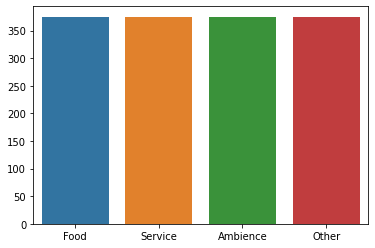

In [26]:
x = ["Food", "Service", "Ambience", "Other"]
y = [len(train_upsampled[train_upsampled.type == 1 ]), len(train_upsampled[train_upsampled.type == 2 ]),  
     len(train_upsampled[train_upsampled.type == 3 ]),  len(train_upsampled[train_upsampled.type == 4 ])]

sns.barplot(x, y)
plt.show()

In [27]:
pipeline_sgd = Pipeline([('vect', CountVectorizer()), 
                         ('tfidf',  TfidfTransformer()), 
                         ('nb', SGDClassifier()),])

pipeline_bnb = Pipeline([('vect', CountVectorizer()), 
                         ('tfidf',  TfidfTransformer()), 
                         ('nb', BernoulliNB()),])

# pipeline_svc = Pipeline([('vect', CountVectorizer()), 
#                          ('tfidf',  TfidfTransformer()), 
#                          ('nb', SVC()),])

pipeline_rfc = Pipeline([('vect', CountVectorizer()), 
                         ('tfidf',  TfidfTransformer()), 
                         ('nb', RandomForestClassifier()),])

In [28]:
X_train, X_test, y_train, y_test = train_test_split(train_upsampled['review_text'],
                                                    train_upsampled['type'],
                                                    random_state = 0)
models = []

model_sgd = pipeline_sgd.fit(X_train, y_train)
model_bnb = pipeline_bnb.fit(X_train, y_train)
# model_svc = pipeline_svc.fit(X_train, y_train)
model_rfc = pipeline_rfc.fit(X_train, y_train)

models.append({"name": "model_sgd", "model": model_sgd})
models.append({"name": "model_bnb", "model": model_bnb})
# models.append({"name": "model_svc", "model": model_svc})
models.append({"name": "model_rfc", "model": model_rfc})

In [29]:
for index in range (len(models)):
    print("Model name:", models[index]['name'])
    y_predict = models[index]['model'].predict(X_test)
    f1_score_result = f1_score(y_test, y_predict, average="weighted")
    accuracy_score_result = accuracy_score(y_test, y_predict)
    precision_score_result = precision_score(y_test, y_predict, average="weighted")

    print("F1 score %s" % round(f1_score_result*100, 2), "%")
    print("Accuracy score %s" % round(accuracy_score_result*100, 2), "%")
    print("Precision score %s" % round(precision_score_result*100, 2), "%")
    print("-----------------------")

Model name: model_sgd
F1 score 87.0 %
Accuracy score 86.93 %
Precision score 87.22 %
-----------------------
Model name: model_bnb
F1 score 81.92 %
Accuracy score 81.87 %
Precision score 83.15 %
-----------------------
Model name: model_rfc
F1 score 89.41 %
Accuracy score 89.33 %
Precision score 89.73 %
-----------------------


In [30]:
pickle.dump(models[2]['model'], open("model", 'wb'))

In [31]:
loaded_model = pickle.load(open("model_types", 'rb'))

In [32]:
print(loaded_model)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('nb', RandomForestClassifier())])


In [33]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", text)
    return text

In [34]:
print(test.size)

396


In [35]:
for i in range (test.size - 1):
    try: 
        review = test.iloc[i]['review_text']
        review = clean_text(review)

        output = ["Food", "Service", "Ambience", "Other"]
        result = loaded_model.predict(pd.Series(review))[0]
        if(result == 3):
            print(review, "<==>", output[int(result)-1])
            print()
    except:
        continue
    

nice atmosphere and our table was on the beach <==> Ambience

the beach is quite dirty at the other side <==> Ambience

awesome live band show check this place <==> Ambience

ambience is good <==> Ambience

very good location right on the beach very relaxing <==> Ambience

beachside seating limited so we ended up sitting in a more enclosed outdoor area <==> Ambience

excellent sea restaurant experience outdoor  and indoor seating areas  ideal for gatherings and parties <==> Ambience

great place on beach  <==> Ambience

located right along the indian beachopen dining to feel the sea free while enjoy the sand under feets <==> Ambience

good atmosphere tables on the sands under the trees decent crowds loved it <==> Ambience

you can have a nice candle lit dinner near the beach <==> Ambience

peaceful and calm environment easy access <==> Ambience

great music and great sea breeze <==> Ambience

has the sea breeze and calm atmosphere for a dinner suitable for large groups of friends or fa